In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, brier_score_loss, roc_auc_score
import seaborn as sns

## HOW DOES THE WHO CRITERIA PERFORM ON THE CONTROL DATASET?

In [21]:
# import dataset from which the model was trained on 

TRAINING_DATA_CLEAN = pd.read_csv('TRAINING_DATA_CLEAN.csv', low_memory=False)

In [22]:
TRAINING_DATA_CLEAN = TRAINING_DATA_CLEAN.set_index('PairsID')

In [23]:
# Load the dataset
who = pd.read_csv('WHO_xN_classifications_TRAINING_DATA.csv', low_memory=False)

# Set the 'PairsID' column as the index
who = who.set_index('PairsID')

In [24]:
# Subset who_df to only include rows that have matching index numbers with df
who = who.loc[who.index.isin(TRAINING_DATA_CLEAN.index)]

# format labels
who = who.map(lambda x: {'NI': 0, 'R': 1}.get(x, x))

In [25]:
# Define the metrics calculation function
def calculate_metrics(y_true, y_pred):
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Precision
    precision = precision_score(y_true, y_pred, average='binary')
    
    # Recall (Sensitivity)
    sensitivity = recall_score(y_true, y_pred, average='binary')
    
    # F1 Score
    f1 = f1_score(y_true, y_pred, average='binary')
    
    # Confusion matrix and specificity
    conf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()  # Extract values from confusion matrix
    
    # Specificity: TN / (TN + FP)
    specificity = tn / (tn + fp)
    
    # If probability scores are available for AUC calculation (use class probabilities instead of class labels)
    try:
        auc = roc_auc_score(y_true, y_pred)
    except ValueError:
        auc = None  # Handle case where AUC can't be computed
    
    return accuracy, precision, sensitivity, specificity, f1 , auc

In [26]:
# Actual labels
y_true = who['labels'].astype(int)

# Initialize an empty list to store the results
results = []

# Loop through all columns except 'labels'
for col in who.columns:
    if col != 'labels':
        y_pred = who[col].astype(int)
        metrics = calculate_metrics(y_true, y_pred)
        # Append the results, including the column name
        results.append([col] + list(metrics))

# Convert results to a DataFrame
metrics_df = pd.DataFrame(results, columns=['Criterion', 'Accuracy', 'Precision', 'Sensitivity (Recall)', 'Specificity', 'F1', 'AUC'])

#sort by AUC
metrics_df = metrics_df.sort_values(by='AUC', ascending=False)

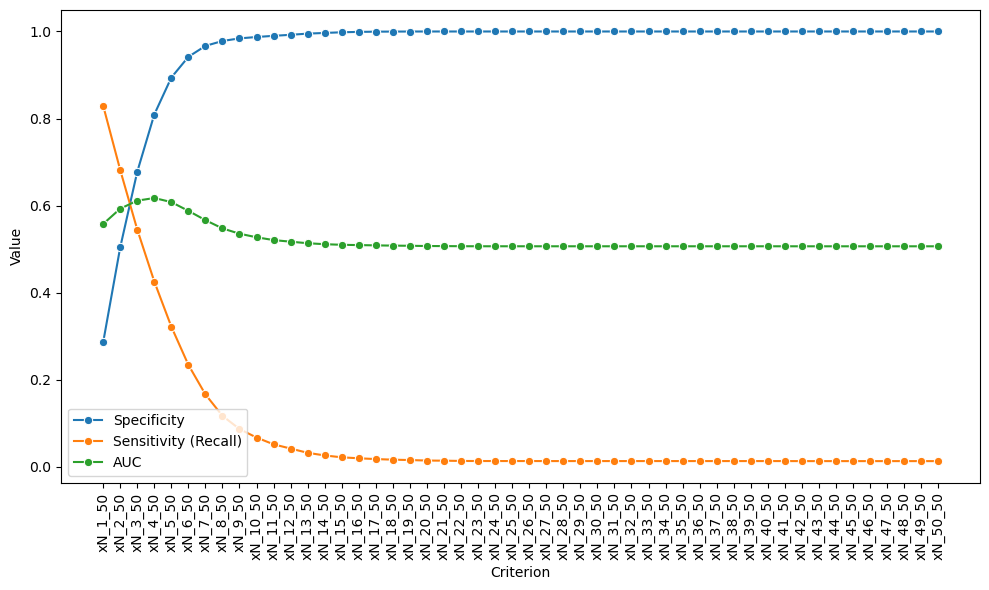

In [27]:
# Extract numeric portion from the 'Criterion' column (after 'xN_') and create a helper column
metrics_df['Numeric_Criterion'] = metrics_df['Criterion'].str.extract(r'xN_(\d+_\d+)')

# Replace '_' with '.' for decimal representation and convert to float
metrics_df['Numeric_Criterion'] = metrics_df['Numeric_Criterion'].str.replace('_', '.').astype(float)

# Sort based on 'Numeric_Criterion', but keep 'classif*' Criterions where they are
metrics_df_sorted = metrics_df.copy()
metrics_df_sorted['Numeric_Criterion'] = metrics_df_sorted['Numeric_Criterion'].fillna(9999)  # Assign large number to non-xN_* values
metrics_df_sorted = metrics_df_sorted.sort_values(by='Numeric_Criterion')

# Remove rows with 'classif*' in the 'Criterion' column
metrics_df_sorted = metrics_df_sorted[~metrics_df_sorted['Criterion'].str.contains('classif')]

# Convert the DataFrame from wide to long format for easier plotting with seaborn
metrics_long = metrics_df_sorted.melt(id_vars=['Criterion'], 
                                      value_vars=['Specificity', 'Sensitivity (Recall)', 'AUC'], 
                                      var_name='Metric', 
                                      value_name='Value')

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(x='Criterion', y='Value', hue='Metric', data=metrics_long, marker='o')

# Add labels and title
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Criterion')
plt.ylabel('Value')
plt.title('')
plt.legend(title='')

plt.tight_layout()
plt.show()


## TES PREDICTIONS

In [74]:
# Load the XGBoost model from the saved joblib file
model_path = 'XGB_MODEL.joblib'
xgb_model_hyperopt = joblib.load(model_path)

#set best known threshold
best_threshold = 0.91

In [75]:
# TES22 features data

TES_data = pd.read_csv('REAL_DATA.csv') 
TES_data = TES_data.set_index('PairsID')

In [76]:

# Make predictions on the out-of-sample (OOS) dataset
y_pred_xgb_tes22 = xgb_model_hyperopt.predict(TES_data)
y_proba_xgb_tes22 = xgb_model_hyperopt.predict_proba(TES_data)[:, 1]  # Probabilities for class 1 (Recrudescent)

y_pred_xgb_tes22_threshold = (y_proba_xgb_tes22 >= best_threshold).astype(int)

In [77]:
TES_data['y_proba_xgb_tes22'] = y_proba_xgb_tes22
TES_data['y_pred_xgb_tes22_threshold'] = y_pred_xgb_tes22_threshold

In [78]:
# Calculate and print the percentage of each unique class: TT
class_percentages = TES_data["y_pred_xgb_tes22_threshold"].value_counts(normalize=True) * 100

for class_label, percentage in class_percentages.items():
    print(f"Class: {class_label}, Percentage: {percentage:.2f}%")

Class: 0, Percentage: 91.38%
Class: 1, Percentage: 8.62%


In [81]:
# Filter rows where y_pred_xgb_tes22_threshold is 1 (Recrudescences)
recrudescence_rows = TES_data[TES_data["y_pred_xgb_tes22_threshold"] == 1]

# report
print(f"\n--- PairsID Predicted as Recrudescent Infections ---\n\n--- Decision Threshold = {str(best_threshold_75_60)} ---\n")
recrudescence_rows[["y_proba_xgb_tes22"]].sort_values(by="y_proba_xgb_tes22", ascending=False)


--- PairsID Predicted as Recrudescent Infections ---

--- Decision Threshold = 0.91 ---



,y_proba_xgb_tes22
PairsID,
47,0.998487
46,0.997623
27,0.993815
29,0.991521
19,0.986434
